# Bernoulli TM implementation

## Loading libraries

In [8]:
# Load libraries
import logging
import pyro

import pyro.distributions as dist
from pyro import poutine

import torch
from torch.distributions import constraints

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(1234)

## Simulate

In [3]:
def LogitNormal(mu, s): 
    base_dist = pyro.distributions.Normal(loc = mu, scale = s)
    response_dist = pyro.distributions.TransformedDistribution(
        base_distribution=base_dist, transforms=torch.distributions.transforms.SigmoidTransform())
    return response_dist

##### Simulation strategy
nCells = 5
nRegions = 3
nTopics = 2
a = torch.ones(nTopics) / 10

# Detection rate (coverage)
cov = dist.Beta(10, 2).sample([nRegions]) + 0.02
# Cell topics distribution
theta = dist.Dirichlet(a).sample([nCells])
# Topics region distribution
phi = LogitNormal(0, 2).sample([nTopics, nRegions])

D_np = np.empty([nCells, nRegions], dtype = np.float16)
# Simulate each cell
for c in range(nCells):
    for r in range(nRegions):
        # Sample topics and corresponding regions
        z = dist.Categorical(theta[c, :]).sample()
        w = dist.Bernoulli(phi[z, r] * cov[r]).sample().detach().tolist()
        D_np[c, r] = w

# Transpose to have nRegions x nCells
D = torch.from_numpy(D_np).t()

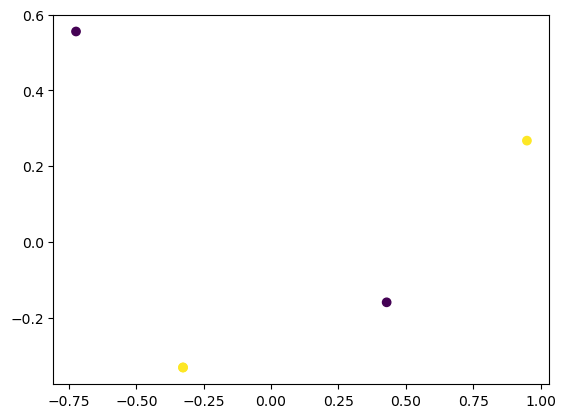

In [4]:
label = theta.detach().numpy()
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(D_np)
plot = plt.scatter(Xt[:,0], Xt[:,1], c = label.argmax(axis=1).tolist())
#plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.show()

In [4]:
#pyro.set_rng_seed(123)
#trace = pyro.poutine.trace(tm_bern_model).get_trace()
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## Bernoulli topic model

Below we define the STM model with Pyro. Note that data D is a matrix of __nRegions x nCells__.

In [5]:
def tm_bern_model(D=None, nTopics=2, nCells=5, nRegions = 3):
    """
    This is a fully generative model of a batch of cells.
    
    :param D: Data matrix, [nRegions, nCells] shaped array
    :param nTopics: Number of topics
    :param nCells: Optional number of cells, used only when D=None to generate a new dataset
    :param nRegions: Optional number of regions, used only when D=None to generate a new dataset
    """
    if D is not None:
        nCells = D.shape[1]
        nRegions = D.shape[0]
    
    # Index matrix on nRegions x nTopics
    idx = torch.arange(0,nRegions).unsqueeze(1).repeat(1, nCells)
    
    # Define reusable context managers
    topics_plate = pyro.plate(name="nTopics", size=nTopics, dim=-1)
    phi_regions_plate = pyro.plate(name="phi_nRegions", size=nRegions, dim=-2)
    
    ## Globals
    # Topic-regions prior
    b = torch.ones([nRegions, nTopics])/10.
    # Topic-cells prior
    alpha = torch.ones(nTopics)/nTopics
    #with topics_plate:
    #    alpha = pyro.sample("alpha", dist.Gamma(1.0 / nTopics, 1.0))
    
    # Topic-regions distribution
    with phi_regions_plate, topics_plate:
        phi = pyro.sample(name="phi", fn=dist.Beta(b, 2))
    ## Locals
    with pyro.plate(name="nCells", size=nCells):
        # Topic-cells distribution
        theta = pyro.sample(name="theta", fn=dist.Dirichlet(alpha))
        with pyro.plate(name="nRegions", size=nRegions):
            # The word_topics variable is marginalized out during inference,
            # achieved by specifying infer={"enumerate": "parallel"} and using
            # TraceEnum_ELBO for inference. Thus we can ignore this variable in
            # the guide.
            z = pyro.sample(name="z", fn=dist.Categorical(theta), infer={"enumerate" : "parallel"})
            print("z shape = {}".format(z.shape))
            print("z = {}".format(z))
            #tmp = Vindex(phi)[z, :]
            tmp = phi[idx, z]
            print("tmp shape = {}".format(tmp.shape))
            print("tmp = {}".format(tmp))
            print("phi shape = {}".format(phi.shape))
            print("phi = {}".format(phi))
            w = pyro.sample(name="w", fn=dist.Bernoulli(tmp), obs=D)
            print("w shape = {}".format(w.shape))
            print("w = {}".format(w))
                 
    obj = dict()
    obj['alpha'] = alpha
    obj['beta'] = b
    obj['theta'] = theta
    obj['phi'] = phi
    obj['D'] = D
    return obj

z shape = torch.Size([3, 5])
z = tensor([[0, 0, 1, 1, 1],
        [1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1]])
tmp shape = torch.Size([3, 5])
tmp = tensor([[8.9217e-20, 8.9217e-20, 1.4491e-07, 1.4491e-07, 1.4491e-07],
        [2.9985e-05, 3.4401e-04, 2.9985e-05, 3.4401e-04, 2.9985e-05],
        [1.2815e-05, 4.7526e-10, 1.2815e-05, 4.7526e-10, 1.2815e-05]])
phi shape = torch.Size([3, 2])
phi = tensor([[8.9217e-20, 1.4491e-07],
        [3.4401e-04, 2.9985e-05],
        [4.7526e-10, 1.2815e-05]])
w shape = torch.Size([3, 5])
w = tensor([[1., 1., 1., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 1.]], dtype=torch.float16)


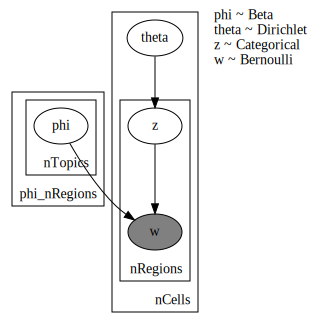

In [6]:
pyro.clear_param_store()
pyro.render_model(tm_bern_model, model_args=(D, nTopics), 
                  render_distributions=True, render_params=True)

## LDA guide (variational approximation)

In [9]:
def tm_bern_guide(D, nTopics=2, nCells=5, nRegions=3):
    """
    Guide implementation of Bernoulli topic model.
    Data is a [nRegions, nCells] shaped array.
    
    :param D: Data matrix, [nRegions, nCells] shaped array
    :param nTopics: Number of topics
    :param nCells: Optional number of cells, used only when D=None to generate a new dataset
    :param nRegions: Optional number of regions, used only when D=None to generate a new dataset
    """
    
    if D is not None:
        nCells = D.shape[1]
        nRegions = D.shape[0]
        
    # Define reusable context managers
    topics_plate = pyro.plate(name="nTopics", size=nTopics, dim=-1)
    phi_regions_plate = pyro.plate(name="phi_nRegions", size=nRegions, dim=-2)
    
    ## Globals
    phi_vi = pyro.param(
        "phi_vi", 
        lambda: dist.LogNormal(loc=0., scale=1).sample([nRegions, nTopics]),
        constraint=constraints.positive)
    theta_vi = pyro.param(
        "theta_vi", 
        lambda: dist.LogNormal(loc=0., scale=0.5).sample([nCells, nTopics]),
        constraint=constraints.positive)
    
    # Iterate over topics and regions
    with phi_regions_plate, topics_plate:
        phi = pyro.sample("phi", dist.Beta(phi_vi, 2))
    
    # Iterate over cells
    with pyro.plate("nCells", nCells):
        # Topic-cells distribution
        theta = pyro.sample("theta", dist.Dirichlet(theta_vi))
                          
    obj = dict()
    obj['theta_vi'] = theta_vi
    obj['phi_vi'] = phi_vi
    obj['theta'] = theta
    obj['phi'] = phi
    obj['D'] = D
    return obj

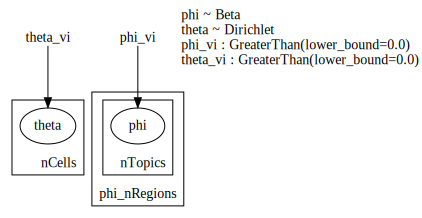

In [10]:
pyro.clear_param_store()
pyro.render_model(tm_bern_guide, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

# Testing variational inference

In [6]:
# Filter to keep only regions with decent coverage
#det_thr = 0.1

#qc_peak_idx = np.where(np.array(D.mean(axis=1)) > det_thr)[0]
#print('Number of peak regions passing QC threshold:', len(qc_peak_idx))
#D_filt = D[qc_peak_idx, :]

Number of peak regions passing QC threshold: 191


## Fit LDA 

To perform inference for TM Bernoulli with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [8]:
nTopics = 2
nSteps = 1000
lr = 0.1
seed = 123

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
optim = pyro.optim.Adam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(tm_bern_model, tm_bern_guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D, nTopics=nTopics)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

    16798 ----------------------------------------
    16798 Fitting 5 cells
    16800 Step	Loss


z shape = torch.Size([2, 1, 1])
z = tensor([[[0]],

        [[1]]])
tmp shape = torch.Size([2, 3, 5])
tmp = tensor([[[0.0489, 0.0489, 0.0489, 0.0489, 0.0489],
         [0.5351, 0.5351, 0.5351, 0.5351, 0.5351],
         [0.0430, 0.0430, 0.0430, 0.0430, 0.0430]],

        [[0.2530, 0.2530, 0.2530, 0.2530, 0.2530],
         [0.1255, 0.1255, 0.1255, 0.1255, 0.1255],
         [0.8425, 0.8425, 0.8425, 0.8425, 0.8425]]], grad_fn=<IndexBackward0>)
phi shape = torch.Size([3, 2])
phi = tensor([[0.0489, 0.2530],
        [0.5351, 0.1255],
        [0.0430, 0.8425]], grad_fn=<SelectBackward0>)
w shape = torch.Size([3, 5])
w = tensor([[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=torch.float16)


RuntimeError: "clamp_min_cpu" not implemented for 'Half'

Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

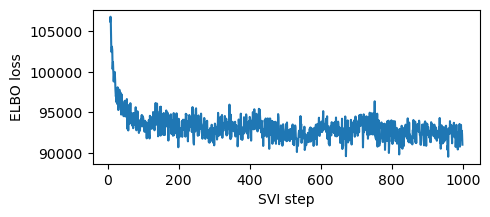

In [25]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [10]:
pyro.param("phi_vi").detach()

tensor([[ 0.3965,  0.3808],
        [ 0.0897, -0.2738],
        [-0.3156, -0.0472],
        [ 0.5523,  0.2615],
        [-0.7903, -0.9836],
        [-1.1578, -1.3414],
        [-0.8630, -0.7810],
        [-0.2613, -0.2607],
        [-0.6136, -0.7556],
        [-1.8363, -1.9187],
        [-0.8989, -0.8888],
        [-0.2882, -0.1666],
        [ 0.5097,  0.4806],
        [-1.4501, -1.4437],
        [-0.9401, -1.0742],
        [ 0.2279,  0.0569],
        [-0.9140, -0.9538],
        [-0.1970,  0.0837],
        [-0.6189, -0.4073],
        [-2.4362, -2.6429],
        [-0.6225, -0.4860],
        [ 0.2786,  0.4633],
        [-0.6842, -0.7221],
        [-0.8933, -0.7476],
        [-0.5384, -0.4713],
        [-0.9788, -0.7927],
        [ 0.5900,  0.8130],
        [-0.3655, -0.3091],
        [-0.0072,  0.0619],
        [-2.9069, -2.7371],
        [-0.2159, -0.1788],
        [ 0.1645,  0.2243],
        [-0.8787, -1.0850],
        [-1.1119, -1.1641],
        [-0.4558, -0.3514],
        [-1.1739, -1

In [ ]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

In [11]:
pyro.param("theta_vi").detach()[1:10, :]

tensor([[3.1986, 0.2766],
        [0.9792, 0.3889],
        [0.7634, 0.6206],
        [0.8869, 0.3890],
        [0.4479, 4.7040],
        [0.7752, 0.7499],
        [0.7921, 0.5903],
        [0.3184, 1.4236],
        [0.7129, 1.4579]])

In [13]:
# A single sample from the guide
post_sample = tm_bern_guide(D = D, nTopics = nTopics)

In [15]:
theta[1:10, ] # first 10 cells prob assignments to each topic

tensor([[3.4710e-01, 6.5290e-01],
        [7.8029e-01, 2.1971e-01],
        [5.0001e-01, 4.9999e-01],
        [1.0000e+00, 3.5922e-08],
        [6.3692e-01, 3.6308e-01],
        [1.7092e-01, 8.2908e-01],
        [1.3939e-01, 8.6061e-01],
        [1.0000e+00, 2.0256e-12],
        [5.7413e-02, 9.4259e-01]])

In [16]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.9634, 0.0366],
        [0.8146, 0.1854],
        [0.7234, 0.2766],
        [0.0655, 0.9345],
        [0.0095, 0.9905],
        [0.1407, 0.8593],
        [0.8495, 0.1505],
        [0.3909, 0.6091],
        [0.3546, 0.6454]], grad_fn=<SliceBackward0>)

In [ ]:
post_sample['phi'][:, 1:10].detach().numpy().transpose() # posterior phi

In [ ]:
d_str = []
for n in range(60):
    d_str.append('w{}'.format(n))
vocab = pd.DataFrame(columns=['id', 'index'])
vocab['id'] = d_str
vocab['index'] = vocab.index

In [ ]:
vocab

In [ ]:
def plot_word_cloud(phi, vocab, max_ids, ax, title):
    """
    Word cloud visualisation helpful for interpreting topic-word distributions

    :param phi: Vector of word probabilities for specific topic
    :param vocab: Vocabulary array with columns ('id', 'index')
    :param max_ids: Maximum number of word ids to plot.
    :param ax: Axis object
    :param title: Plot title
    """
    sorted_, indices = torch.sort(phi, descending=True)
    df = pd.DataFrame(indices[:max_ids].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'id']],
                     how='left', on='index')['id'].values.tolist()
    sizes = (sorted_[:100] * 10).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title(title)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    
phi = post_sample['phi']
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
for n in range(phi.shape[0]):
    i, j = divmod(n, 2)
    plot_word_cloud(scale_zero_one(phi[n]), vocab, 20, axs[i, j], 'Topic %d' % (n + 1))

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
for n in range(obj_sim['phi_true'].shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(scale_zero_one(obj_sim['phi_true'][n]), vocab, 20, axs[i, j], 'Topic %d' % (n + 1))
axs[-1, -1].axis('off');

plt.show()

## Automatic Delta guide

In [ ]:
# Simulate data
nTopics = 2    # Topics
nCells = 1000    # Cells
nRegions = 200 # Regions
N = [100] * nCells # Cells size
a = [1/5] * nTopics
b = [1/10] * nRegions
# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = a, b = b)
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

In [ ]:
auto_guide = AutoDelta(poutine.block(lda_model, expose=['theta', 'phi']))
pyro.render_model(auto_guide, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

In [ ]:
obj['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

In [ ]:
obj['phi_true'][:, 1:10].transpose() # first 10 region-topic probs

### Fit auto LDA

In [ ]:
def fit_auto_lda(D, nTopics, nRegions, nSteps = 1000, lr = 0.01, seed = 1):
    """
    Fit auto LDA
    """
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()

    # We'll fit using SVI.
    logging.info("-" * 40)
    logging.info("Fitting {} cells".format(D.shape[1]))

    elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
    optim = pyro.optim.Adam({"lr": lr})
    svi = pyro.infer.SVI(lda_model, auto_guide, optim, elbo)
    losses = []
    
    logging.info("Step\tLoss")
    for step in range(nSteps):
        loss = svi.step(D=D, nTopics=nTopics, nRegions=nRegions)
        if step % 100 == 0:
            logging.info("{: >5d}\t{}".format(step, loss))
        losses.append(loss)
    logging.info("final loss = {}".format(loss))

    obj = dict()
    obj['losses'] = losses
    return obj

pyro.clear_param_store()
obj = fit_auto_lda(D = D, nTopics = nTopics, nRegions = nRegions, nSteps = 1000, lr = 0.01, seed = 123)

In [ ]:
# plot ELBO losses
losses = obj['losses']

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")